# plot "long-range LNC" effects using HCP data

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
code_dir = '/home/nblauch/git/imaging_neuro'
sys.path.append(code_dir)

In [2]:
from func.hcp_plotting_funs import spearman_p_to_r, get_roi_from_atlas
from statsmodels.stats.multitest import fdrcorrection
from func.masking import RAJIMEHR_ROIS
from func.hcp import ROIS_DICT

/home/nblauch/anaconda3/envs/drive-suppress-brains/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


#### replicate Rajimehr results of lang vs. social competition
Note: Rajimehr used laterality difference (L-R), whereas we used the laterality index (L-R)/(L+R)

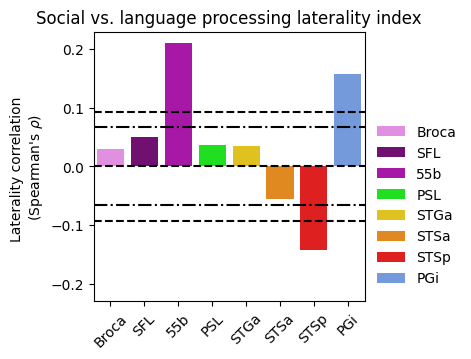

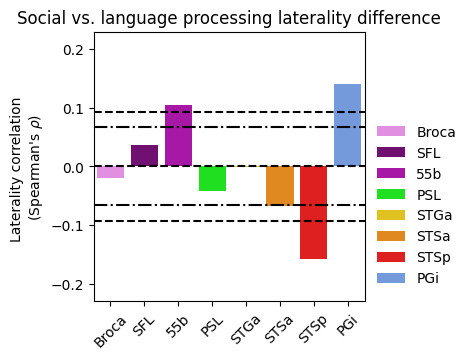

In [3]:
corrs = pd.read_csv(f'{code_dir}/data/hcp_social_language_laterality_hand-R.csv')
all_rois = RAJIMEHR_ROIS.keys()
dofs = corrs['dof'].values
assert len(np.unique(dofs)) == 1, 'all dofs must be the same'
dof = np.unique(dofs)[0]

laterality_name_dict = {'laterality':'laterality index', 'laterality_diff':'laterality difference'}

for laterality_style, laterality_name in laterality_name_dict.items():
    these_corrs = corrs[corrs['laterality_style'] == laterality_style]

    ceil = spearman_p_to_r(0.05/len(all_rois), dof)
    ceil_unc = spearman_p_to_r(0.05, dof)

    plt.figure(figsize=(3.5,3.5), dpi=100)
    sns.barplot(data=these_corrs, hue='roi', y='r', x='roi', palette='rajimehr_novtc', dodge=False)
    plt.axhline(0, color='k', linestyle='--')
    plt.axhline(ceil, color='k', linestyle='--')
    plt.axhline(-ceil, color='k', linestyle='--')
    plt.axhline(ceil_unc, color='k', linestyle='-.')
    plt.axhline(-ceil_unc, color='k', linestyle='-.')
    plt.xticks(rotation=45)
    plt.legend(loc='upper left', bbox_to_anchor=[1.0,0.7]).get_frame().set_linewidth(0)
    plt.title(f'Social vs. language processing {laterality_name}')
    plt.ylabel("Laterality correlation \n" + r"(Spearman's $\rho$)")
    # plt.xlabel('Individual language localization mirroring')
    plt.xlabel('')
    # plt.xticks([0,1], ['Anat.', 'Lang. loc \nmirror'])
    plt.ylim(-.23, .23)
    plt.legend(loc='upper left', bbox_to_anchor=[1.0,0.7]).get_frame().set_linewidth(0)
    plt.show()


# main handedness

In [4]:
df = pd.read_csv(f'{code_dir}/data/rajimehr_hcp_long_range_corrs.csv')

<Figure size 2000x300 with 0 Axes>

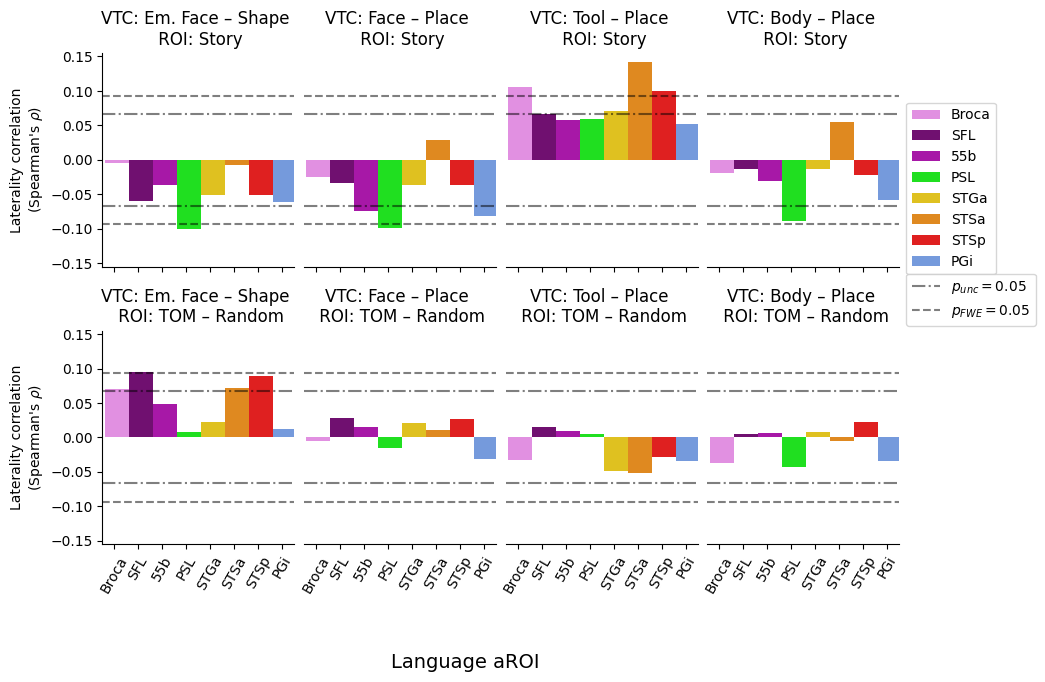

In [5]:
y='r'
y_label = "Laterality correlation\n" + r"(Spearman's $\rho$)"
roi = 'VTC'
hand_thresh = 40

this_df = df[(df.ROI_1 == roi) & (df.hand_thresh == hand_thresh)]

n_groups = len(this_df['map1-map2'].unique())

plt.figure(dpi=100, figsize=(2.5*n_groups,3))
barplot = sns.FacetGrid(data=this_df, col="map1-map2", height=3, aspect=0.75, col_wrap=4)

# Map the barplot to each facet
barplot.map_dataframe(sns.barplot, x="ROI_2", y=y, hue='ROI_2', dodge=False, palette='rajimehr_novtc')

barplot.set_xticklabels(rotation=60)

for ii, ax in enumerate(barplot.axes.reshape(-1)):
    plt.sca(ax)
    title = ax.get_title()
    ax.set_title(title.replace('map1-map2 = ', ''))
    ax.set_xlabel('')
    ax.set_xticklabels(this_df['ROI_2'].unique())
    if ii == 3:
        leg = plt.legend(loc='upper left', bbox_to_anchor=[1,0.8])
        plt.gca().add_artist(leg)
        
    if y == 'r':
        plt.axhline(np.max(this_df['ceil']), 0, 1, color='k', linestyle='--', label=r'$p_{FWE}=0.05$', alpha=0.5)
        plt.axhline(np.max(this_df['ceil_unc']), 0, 1, color='k', linestyle='-.', label=r'$p_{unc}=0.05$', alpha=0.5)
        plt.axhline(np.min(this_df['-ceil']), 0, 1, color='k', linestyle='--', alpha=0.5)
        plt.axhline(np.min(this_df['-ceil_unc']), 0, 1, color='k', linestyle='-.', alpha=0.5)

    plt.ylabel(y_label)
    handles, labels = plt.gca().get_legend_handles_labels()
    if ii == 3:
        ind_unc = list(labels).index(r'$p_{unc}=0.05$')
        ind_fwe = list(labels).index(r'$p_{FWE}=0.05$')
        plt.legend([handles[ind_unc], handles[ind_fwe]], 
                    [labels[ind_unc], labels[ind_fwe]], 
                    bbox_to_anchor=[1,0], loc='upper left')
    if ii != 0 and ii != 4:
        ax.tick_params(axis='y', which='both', length=0)  # Remove tick marks
        ax.set_ylabel('')  # Optional: Remove y-labels for intermediate plots
        ax.spines['left'].set_visible(False)

for ax in barplot.axes.flat:
    for bar in ax.patches:
        bar.set_width(1)  # Adjust the factor as needed

barplot.fig.text(0.5, -0.1, 'Language aROI', ha='center', va='center', fontsize=14)

# Reduce the spacing between the plots
barplot.fig.subplots_adjust(wspace=0.05, hspace=.3)

if y == 'r':
    plt.ylim(-0.155, 0.155)
else:
    plt.ylim(-5,5)

plt.show()

# across handedness thresholds

In [6]:
from func.hcp import get_subs_by_handedness
ceils = []
ceils_unc = []
for hand_thresh in np.arange(-100,100,10):
    subjects, _ = get_subs_by_handedness('T', hand_thresh)
    dof = len(subjects)
    ceil = spearman_p_to_r(0.05/6, dof) # FWE
    ceil_unc = spearman_p_to_r(0.05, dof) # unc.
    ceils.append(ceil)
    ceils_unc.append(ceil_unc)
ceils = np.array(ceils)
ceils_unc = np.array(ceils_unc)

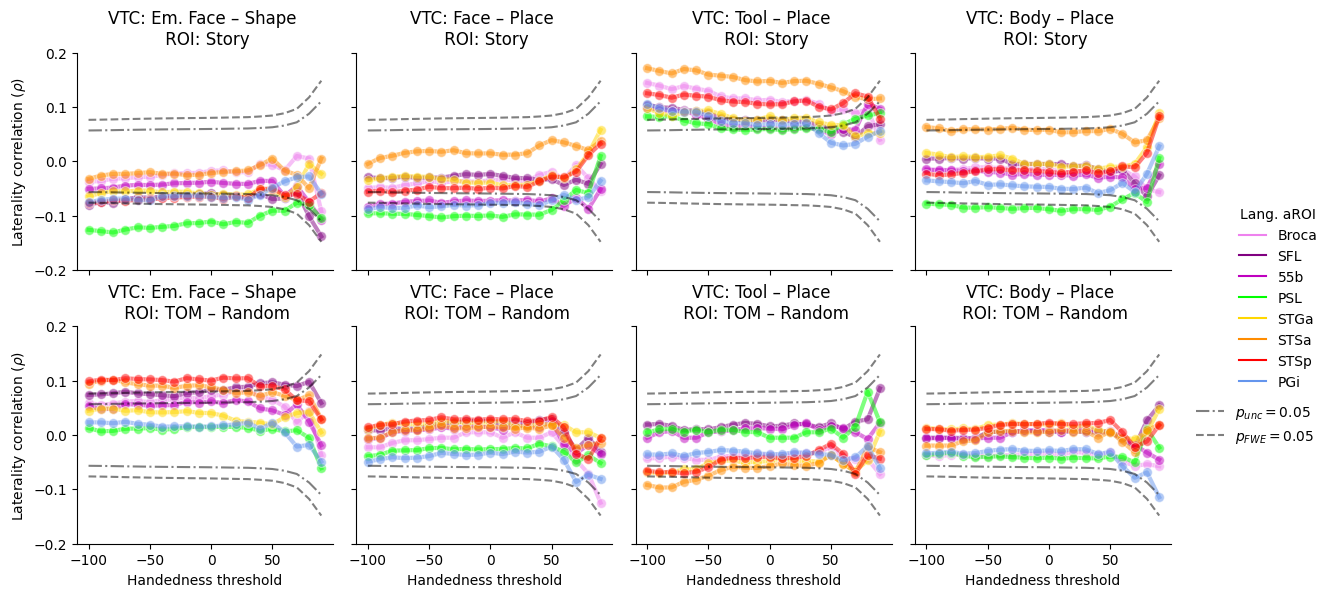

In [7]:
cmap = 'rajimehr_novtc'
use_markers = True

kwargs = dict(marker='o', markersize=7) if use_markers else {}
m_tag = '_markers' if use_markers else ''
facet = sns.relplot(data=df[(df.ROI_1 == 'VTC')], x='hand_thresh', y='r', col='map1-map2', hue='ROI_2', col_wrap=4, 
                    kind='line', height=3, linewidth=3, alpha=0.5, palette=cmap, **kwargs)
plt.ylim(-.2,.2)
leg = facet._legend
leg.set_title('Lang. aROI') 
for ii, ax in enumerate(facet.axes):
    plt.sca(ax)
    title = ax.get_title()
    if len(ax.get_ylabel()):
        ax.set_ylabel(r'Laterality correlation ($\rho$)')
    plt.xlabel('Handedness threshold')
    ax.set_title(title.replace('map1-map2 = ', ''))
    handle = plt.plot(np.arange(-100,100,10), ceils, color='k', linestyle='--', alpha=0.5) #, zorder=1)
    plt.plot(np.arange(-100,100,10), -ceils, color='k', linestyle='--', alpha=0.5) #, zorder=1)
    handle_unc = plt.plot(np.arange(-100,100,10), ceils_unc, color='k', linestyle='-.', alpha=0.5) #, zorder=1)
    plt.plot(np.arange(-100,100,10), -ceils_unc, color='k', linestyle='-.', alpha=0.5) #, zorder=1)
    if ii == len(facet.axes)-1:
        ax.legend([handle_unc[0], handle[0]], [r'$p_{unc}=0.05$', r'$p_{FWE}=0.05$'], loc='upper left', bbox_to_anchor=[1.05,0.7]).get_frame().set_linewidth(0)
        
plt.show()